# Image Captioning

In this Notebook you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Отчёт

Содержит 4 секции с моделями и секцию с описаниями изображений из Интернета.

*Резюме по моделям* 

 - Удалось пробить loss 2.5 (3 модель получилась с loss **2.48**)
 - Были проведены эксперименты с:
    - размером скрытого слоя
    - размером бача
    - колличеством эпох
    
 - Считал, что во 2 и 3 модели градиентные взрывы, но это tensorboard записал подряд несколько моделей, и поэтому получались такие скачки, проверил тем, что запустил вторую модель с перезапущеного колаба.
 
 - Последняя модель (ниже отчёта) получилась с loss **2.46** 
 
 ![alt text](https://drive.google.com/uc?export=view&id=13bp3pxrXbQ3mPRUL_MoB4shYCL3mnU6-)

## Первый вариант модели

In [0]:
batch_size = 128
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 256
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]


In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 4.301545
Epoch: 0, train loss: 4.3015449709892275, val loss: 3.6837714648246767
**************************************************
Training loss: 3.352553
Epoch: 1, train loss: 3.3525531640052795, val loss: 3.1596914982795714
**************************************************
Training loss: 3.001179
Epoch: 2, train loss: 3.0011794199943544, val loss: 2.9717910051345826
**************************************************
Training loss: 2.860607
Epoch: 3, train loss: 2.86060732626915, val loss: 2.86189240694046
**************************************************
Training loss: 2.772619
Epoch: 4, train loss: 2.7726192421913147, val loss: 2.80155421257019
**************************************************
Training loss: 2.696938
Epoch: 5, train loss: 2.6969382870197296, val loss: 2.7619792151451112
**************************************************
Training loss: 2.651847
Epoch: 6, train loss: 2.6518465762138366, val loss: 2.7

In [0]:
# Validation loss, you should go below ~2.7
print(grading_utils.test_validation_loss(decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************

2.595777720451355


In [0]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=2)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.4348803
Accuracy: 0.489851150202977
Example 0
Predicted: 15 1971 1971 13th 19 18 1971 19 00 1971 #PAD# 19 18 1971 1971 00 19 1971 #END# 1971 #END# 1971 19 1971 13 18 14 18 1971 00 19 1950 #END# 19 1971 #PAD# 13th #END# 19 18 19 19 1971 19 19 00 #END# 13th 12 1971 13 1971 1971 1971 #END# #END# #PAD# #END# 1971 #START# 1971 16 15 13th #PAD# 1971 13 00 13th 13th 12 19 1971 13th 13th 1971 #UNK# 1971 1 #PAD# 16 #PAD# 1971 #END# 1971 16 #PAD# 18 13th 1971 00 13th 1971 1971 #UNK# 1971 #UNK# 12 1971 1971 15 1971 15 1971 1971 1971 #END# 1971 1971 #PAD# #START# 11 00 #END# 13 1971 #UNK# #UNK# 13 #END# #END# #PAD# #UNK# #END# 1971 1971 13th 1971 1971 #UNK# #UNK# #END# 1950 #END# #END# #PAD# #END# 15 13th #END# 1971 #END# 13th 17 13th 17 15 14 #PAD# #END# 1971 #PAD# 13th 17 13th 1971 15 15 12 19 #END# 14 1971 #START# 1 #START# 13 13 13th 14 00 #START# 1971 1971 13th 12 #UNK# 13th #END# 13th 1971 #PAD# 13 13 13 1971 #END# 17 1971 18 1971 00 17 00 13th #END# 1971 00 16 19 1971 15 #END# #PAD#

![alt text](https://drive.google.com/uc?export=view&id=1UlWmwMeGgXSc-_qZSEMMMXXPyt8a2saC)

## Второй вариант модели 

*Резюме* :  
- Увеличиваем размер бача с **64** до **128**
- Увеличиваем размер скрытого слоя с **256** до **512**

Получаем loss лучше, чем был (**2.60** -> **2.50**), однако кривая обучения с градиентным взрывом => нужно уменьшить LR у оптимизатора

In [0]:
batch_size = 128
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 512
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 4.086784
Epoch: 0, train loss: 4.086784347295761, val loss: 3.3421408128738403
**************************************************
Training loss: 3.067077
Epoch: 1, train loss: 3.067076606750488, val loss: 2.945188653469086
**************************************************
Training loss: 2.811263
Epoch: 2, train loss: 2.8112634301185606, val loss: 2.821326217651367
**************************************************
Training loss: 2.690439
Epoch: 3, train loss: 2.6904394977092743, val loss: 2.717609622478485
**************************************************
Training loss: 2.611593
Epoch: 4, train loss: 2.6115925357341765, val loss: 2.651689734458923
**************************************************
Training loss: 2.547819
Epoch: 5, train loss: 2.547819478034973, val loss: 2.622873423099518
**************************************************
Training loss: 2.498075
Epoch: 6, train loss: 2.498074639558792, val loss: 2.5970

In [0]:
# Validation loss, you should go below ~2.7
print(grading_utils.test_validation_loss(decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************

2.504996908187866


![alt text](https://drive.google.com/uc?export=view&id=1D5yxa7lrXyoasy-ny94hOQ0gMUwZ2wiV)

## Третий вариант модели

*Резюме:*

- Возвращаем размер бача **64**
- Увеличиваем кол-во эпох с **12** до **20**

Получаем loss лучше, чем был (**2.50** -> **2.48**), но кривая обучения полна градиентных взрывов.

In [0]:
batch_size = 64
n_epochs = 20
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 512
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# actual training loop
MAX_LEN = 25  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 2.393154
Epoch: 0, train loss: 2.3931543519496916, val loss: 2.5254900431632996
**************************************************
Training loss: 2.370463
Epoch: 1, train loss: 2.370462500810623, val loss: 2.5471755170822146
**************************************************
Training loss: 2.354295
Epoch: 2, train loss: 2.354294956445694, val loss: 2.5405668783187867
**************************************************
Training loss: 2.347967
Epoch: 3, train loss: 2.347966728448868, val loss: 2.520211374759674
**************************************************
Training loss: 2.341527
Epoch: 4, train loss: 2.341526798248291, val loss: 2.519467213153839
**************************************************
Training loss: 2.324019
Epoch: 5, train loss: 2.3240188776254653, val loss: 2.5349332213401796
**************************************************
Training loss: 2.319212
Epoch: 6, train loss: 2.3192122176885603, val loss: 2.5

In [0]:
# Validation loss, you should go below ~2.7
print(grading_utils.test_validation_loss(decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************

2.478150579571724


![alt text](https://drive.google.com/uc?export=view&id=1plTiIQLDLgsx0vC38s3sz_fGqQoI5GfV)

## Четвёртый вариант модели

- Уменьшили LR в 10 раз

Получилось без взрывов, но попали в локальный минимум

In [0]:
# actual training loop
MAX_LEN = 25  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 5.164060
Epoch: 0, train loss: 5.164060296058655, val loss: 4.490156807899475
**************************************************
Training loss: 4.216161
Epoch: 1, train loss: 4.2161609261035915, val loss: 3.9925420928001403
**************************************************
Training loss: 3.765266
Epoch: 2, train loss: 3.7652663745880126, val loss: 3.607703731060028
**************************************************
Training loss: 3.467986
Epoch: 3, train loss: 3.467985937833786, val loss: 3.3910441470146178
**************************************************
Training loss: 3.309724
Epoch: 4, train loss: 3.309724208831787, val loss: 3.2657844686508177
**************************************************
Training loss: 3.193305
Epoch: 5, train loss: 3.193304769039154, val loss: 3.1790806603431703
**************************************************
Training loss: 3.106186
Epoch: 6, train loss: 3.106185881853104, val loss: 3.10

In [0]:
# Validation loss, you should go below ~2.7
print(grading_utils.test_validation_loss(decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************

2.5089554195404054


![alt text](https://drive.google.com/uc?export=view&id=1n7BjZUCZikIrN4mex-Nucza1PpDbu08l)

## Примеры описания картинок из Интернета

**************************************************
portal-cake-10.jpg
a chocolate cake with a white and black frosting cake


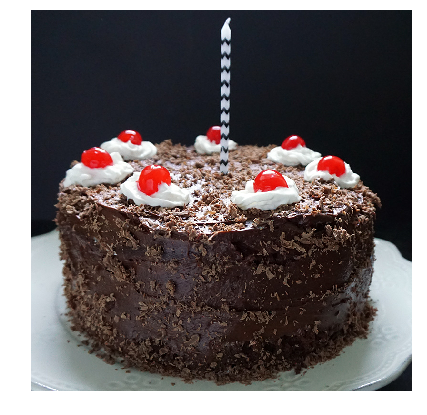

In [0]:
download_utils.download_file(
    "http://www.bijouxandbits.com/wp-content/uploads/2016/06/portal-cake-10.jpg",
    "portal-cake-10.jpg"
)
apply_model_to_image_raw_bytes(open("portal-cake-10.jpg", "rb").read())

Видимо, светчка определилась как торт

**************************************************
sk8.jpg
a skateboard that is sitting on the ground


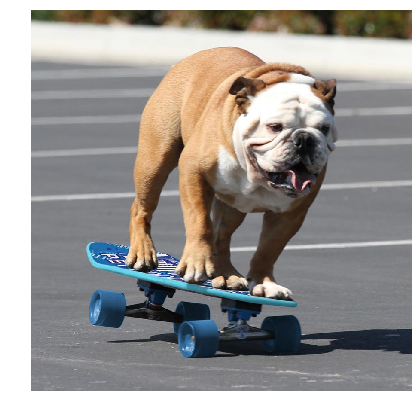

In [0]:
download_utils.download_file(
    "https://i.kym-cdn.com/entries/icons/original/000/019/170/illman.jpg",
    "sk8.jpg"
)
apply_model_to_image_raw_bytes(open("sk8.jpg", "rb").read())

Скейтборд не сидит на земле

**************************************************
flash.jpg
a person holding a red and white umbrella


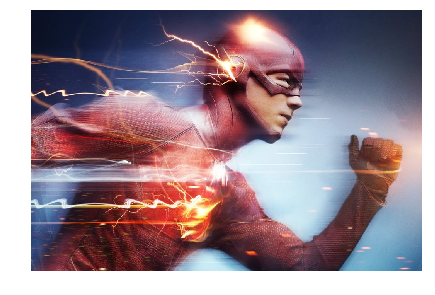

In [0]:
download_utils.download_file(
    "http://www.sciencemadesimple.co.uk/files/2016/06/theflash_gallery_flash_1200_article_story_large.jpg",
    "flash.jpg"
)

apply_model_to_image_raw_bytes(open("flash.jpg", "rb").read())

Определен человек, определены красный и белые цвета, но вот зонтика здесь не видно

**************************************************
catdog.jpg
a teddy bear sitting on a wooden bench


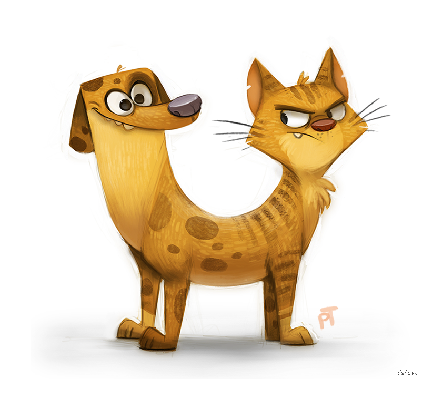

In [0]:
download_utils.download_file(
    "https://cs4.pikabu.ru/post_img/big/2014/04/29/9/1398780551_487200739.png",
    "catdog.jpg"
)

apply_model_to_image_raw_bytes(open("catdog.jpg", "rb").read())

Нет ни деревянной скамейки, ни плюшевого мишки :-(

**************************************************
kitten.jpg
a cat is laying on a bed with a blanket


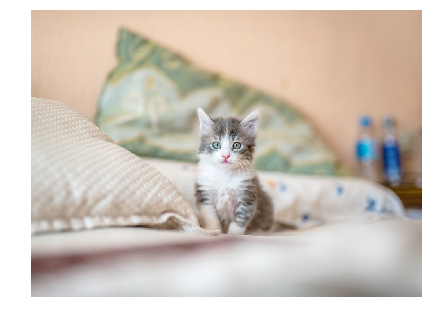

In [0]:
download_utils.download_file(
    "https://images.unsplash.com/photo-1533743983669-94fa5c4338ec?ixlib=rb-1.2.1&dpr=1&auto=format&fit=crop&w=1000&q=80&cs=tinysrgb",
    "kitten.jpg"
)

apply_model_to_image_raw_bytes(open("kitten.jpg", "rb").read())

Всё описано верно

**************************************************
fishing.jpg
a man and a woman are rowing in the water


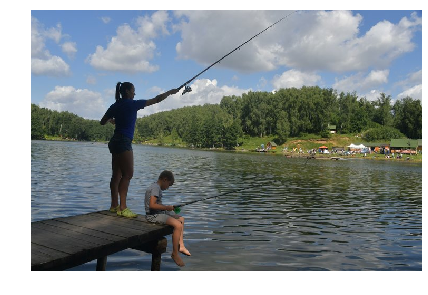

In [0]:
download_utils.download_file(
    "https://b1.vestifinance.ru/c/362530.742xp.jpg",
    "fishing.jpg"
)

apply_model_to_image_raw_bytes(open("fishing.jpg", "rb").read())

Увы, но они рыбачат, а не гребут

# Setup Google Colab

Downloads scripts and data

In [0]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
setup_google_colab.setup_week6()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2018-12-16 08:16:14--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2018-12-16 08:16:14 (55.5 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]

**************************************************
captions_train-val2014.zip
**************************************************
train2014_sample.zip
**************************************************
train_img_embeds.pickle
**************************************************
train_img_fns.pickle
*****************

# Import stuff

In [0]:
import sys
sys.path.append("..")
import grading
import download_utils

In [0]:
download_utils.link_all_keras_resources()

In [0]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os
from keras_utils import reset_tf_session
import tqdm_utils
from collections import Counter

Using TensorFlow backend.


# Prepare the storage for model checkpoints

You will need a Google account!

In [0]:
# Leave USE_GOOGLE_DRIVE = False if you're running locally!
# We recommend to set USE_GOOGLE_DRIVE = True in Google Colab!
# If set to True, we will mount Google Drive, so that you can restore your checkpoint 
# and continue trainig even if your previous Colab session dies.
# If set to True, follow on-screen instructions to access Google Drive (you must have a Google account).
USE_GOOGLE_DRIVE = True

def mount_google_drive():
    from google.colab import drive
    mount_directory = "/content/gdrive"
    drive.mount(mount_directory)
    drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0] + "/colab"
    return drive_root

CHECKPOINT_ROOT = ""
if USE_GOOGLE_DRIVE:
    CHECKPOINT_ROOT = mount_google_drive() + "/"

def get_checkpoint_path(epoch=None):
    if epoch is None:
        return os.path.abspath(CHECKPOINT_ROOT + "weights")
    else:
        return os.path.abspath(CHECKPOINT_ROOT + "weights_{}".format(epoch))
      
# example of checkpoint dir
print(get_checkpoint_path(10))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/colab/weights_10


# Link data

Takes 10 hours and 20 GB. We've already downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

In [0]:
# we downloaded them for you, just link them here
download_utils.link_week_6_resources()

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/inceptionv3.png?raw=1" style="width:70%">

In [0]:
IMG_SIZE = 299

In [0]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

Features extraction takes too much time on CPU:
- Takes 16 minutes on GPU.
- 25x slower (InceptionV3) on CPU and takes 7 hours.
- 10x slower (MobileNet) on CPU and takes 3 hours.

So we've done it for you with the following code:
```python
# load pre-trained model
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))
            
sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")
```

In [0]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [0]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

# Extract captions for images

In [0]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


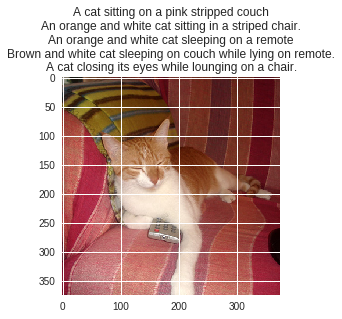

In [0]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [0]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [0]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    wc = Counter([word for sentence_group in train_captions for sentence in sentence_group for word in split_sentence(sentence)])
    vocab = [word for word in wc if wc[word] >= 5]
    vocab += [PAD, UNK, START, END]
    return {token: index for index, token in enumerate(sorted(vocab))}
    
ex = [['A tabby cat sitting in front of a car.', 'A brown and black cat sitting on driveway next to a white car.',
       'A sleepy looking cat sitting in front of a white car.', 'A cat sits in front of a parked car.',
       'A cat sitting in front of a parked white car.']]
assert (len(generate_vocabulary(ex)) == 7 and 'cat' in generate_vocabulary(ex))

    
def caption_tokens_to_indices(captions, vocab):
  res = []
  for img_cap in captions:
    img_idx_cap = []

    for caption in img_cap:
      sentence = []
      
      sentence.append(vocab[START])
      for word in split_sentence(caption):
        if word not in vocab:
          sentence.append(vocab[UNK])
        else:
          sentence.append(vocab[word])
      sentence.append(vocab[END])

      img_idx_cap.append(sentence)

    res.append(img_idx_cap)

  return res  

In [0]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [0]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)


Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [0]:
# we will use this during training
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if not max_len:    
      length = max(map(len, batch_captions))
    else:
      length = min(max_len, max(map(len, batch_captions)))
    
    matrix = np.array([list(xi[:length])+[pad_idx]*(length-len(xi)) for xi in batch_captions])
    
    return matrix
  
in_ex = np.array([np.array([1, 2, 3]), np.array([4, 5])])
assert np.array_equal(np.array([np.array([1, 2]), np.array([4, 5])]), batch_captions_to_matrix(in_ex, 9, 2))
assert np.array_equal(np.array([np.array([1, 2, 3]), np.array([4, 5, 9])]), batch_captions_to_matrix(in_ex, 9, 3))
assert np.array_equal(np.array([np.array([1, 2, 3]), np.array([4, 5, 9])]), batch_captions_to_matrix(in_ex, 9, None))

In [0]:
# make sure you use correct argument in caption_tokens_to_indices

assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/encoder_decoder_explained.png?raw=1" style="width:50%">

In [0]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 512
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [0]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="https://github.com/ZEMUSHKA/mml-minor/blob/master/hw/images/flatten_help.jpg?raw=1" style="width:80%">

In [0]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE),
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:, :-1])
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(hidden_states))
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = sentences[:, 1:]

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.logical_not(tf.equal(flat_ground_truth, pad_idx))

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [0]:
# define optimizer operation to minimize the loss
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# test random decoder loss, should get ~9
print(grading_utils.test_random_decoder_loss(decoder, IMG_EMBED_SIZE, vocab, s))

9.078204


In [0]:
# look at the shapes, can help with debug
def print_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s):
    tensors_to_test = [
        decoder.h0,
        decoder.word_embeds,
        decoder.flat_hidden_states,
        decoder.flat_token_logits,
        decoder.flat_ground_truth,
        decoder.flat_loss_mask,
        decoder.loss
    ]
    all_shapes = []
    for t in tensors_to_test:
        _ = s.run(t, feed_dict=grading_utils.get_feed_dict_for_testing(decoder, IMG_EMBED_SIZE, vocab))
        print("{}: {}".format(t.name, _.shape))
        
print_decoder_shapes(decoder, IMG_EMBED_SIZE, vocab, s)

dense_1/Elu:0: (32, 512)
embedding/embedding_lookup/Identity_2:0: (32, 19, 100)
Reshape:0: (608, 512)
dense_3/BiasAdd:0: (32, 19, 8769)
strided_slice_1:0: (32, 19)
LogicalNot:0: (32, 19)
Mean:0: ()


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [0]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [0]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    idx = np.random.randint(0, images_embeddings.shape[0], batch_size)
    
    batch_image_embeddings = images_embeddings[idx]
    
    #                                                                         V В выборке 5 предложений
    batch_captions_matrix = batch_captions_to_matrix([xi[np.random.randint(0, 5)] for xi in indexed_captions[idx]], pad_idx, max_len)    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [0]:
batch_size = 128
n_epochs = 30
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

In [0]:
# you can load trained weights here
# uncomment the next line if you need to load weights
#saver.restore(s, get_checkpoint_path(epoch=12))

Look at the training and validation loss, they should be decreasing!

In [0]:
# run tensorboard in background
import os
os.system("tensorboard --logdir=./logs --host 0.0.0.0 --port 6006 &")

# expose port and show the link
setup_google_colab.expose_port_on_colab(6006)

Can't get public url, retrying...
Open http://5fd8a7a9.ngrok.io to access your 6006 port


In [0]:
tf.summary.scalar('train_loss', decoder.loss)
summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("logs/1", s.graph)

In [0]:
# actual training loop
MAX_LEN = 25  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        batch_train_loss, _, curr_summaries = s.run(
            [decoder.loss, train_step, summaries], 
            generate_batch(train_img_embeds, train_captions_indexed, batch_size, MAX_LEN)
        )
        train_loss += batch_train_loss
        summary_writer.add_summary(curr_summaries)
        summary_writer.flush()
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, get_checkpoint_path(epoch))
    
print("Finished!")

**************************************************
Training loss: 4.079511
Epoch: 0, train loss: 4.079511237382889, val loss: 3.2922203516960145
**************************************************
Training loss: 3.050428
Epoch: 1, train loss: 3.0504281606674195, val loss: 2.9411880946159363
**************************************************
Training loss: 2.806556
Epoch: 2, train loss: 2.8065563356876373, val loss: 2.8102882862091065
**************************************************
Training loss: 2.686594
Epoch: 3, train loss: 2.6865937032699585, val loss: 2.716005358695984
**************************************************
Training loss: 2.606871
Epoch: 4, train loss: 2.6068714933395385, val loss: 2.651306710243225
**************************************************
Training loss: 2.542741
Epoch: 5, train loss: 2.5427412981987, val loss: 2.621498603820801
**************************************************
Training loss: 2.493099
Epoch: 6, train loss: 2.493098814725876, val loss: 2.590

In [0]:
# Validation loss, you should go below ~2.7
print(grading_utils.test_validation_loss(decoder, s, generate_batch, val_img_embeds, val_captions_indexed))

**************************************************

2.4657326320409774


In [0]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=2)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.0667734
Accuracy: 0.5252525252525253
Example 0
Predicted: 13th 13 13 1971 17 #END# 2 2 2 15 #PAD# 2 15 19 18 18 2 15 17 13 1 2 15 1971 #PAD# 2 15 2 2 1 15 2 13 18 2 #PAD# 13 1 18 15 2 2 13 15 17 2 2 14 13 2 2 2 2 17 #END# #END# 00 00 2 14 14 14 13th #END# #PAD# 13 14 #UNK# 10 13 13 1 14 13 2 17 13 14 2 #END# 00 16 14 #END# 15 #PAD# #END# 16 #END# 2 #END# #PAD# 16 17 14 2 2 13 13 2 17 1 00 13 1st #END# #UNK# 17 14 2 #PAD# 2 1 1 #PAD# 13th #UNK# #UNK# 2 #END# #END# #PAD# #END# 13 17 15 14 13 14 #UNK# 13th #END# #START# 13 16 13 14 13th 2 13 15 #END# 2 00 #PAD# 14 00 1950 #PAD# 16 00 #END# 16 14 2 1 17 13 1 13 1 1950 #END# 13 2 00 2 #START# 2 #START# 1971 #START# #PAD# #START# 16 13 #PAD# 15 1 2 1st 12 1st 1950 13 2 14 #PAD# 1st 1 2 14 #END# 13th 15 15 #PAD# 1 17 00 14 17 00 #PAD# 1 2 00 13th 13th 00 13th 1 #END# 13th 13th #PAD# #END# 16 1st 10 1 #END# 13 13 #PAD# 13 13 1 15 13 14 13th 1 00 13th 2 2 13 1 13 #PAD# 1st #END# #END# 2 13 15 2 2 11 2 15 1971 #PAD# #START# 1950 14 1950 

In [0]:
# save last graph weights to file!
saver.save(s, get_checkpoint_path())

'/content/gdrive/My Drive/colab/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [0]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, get_checkpoint_path())  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/colab/weights


In [0]:
# look at how temperature works for probability distributions
# for high temperature we have more uniform distribution
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.9999999997962965 2.0370359759195462e-10 1.2676505999700117e-70 with temperature 0.01
0.9030370433250645 0.09696286420394223 9.247099323648666e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.35344772639219624 0.34564811360592396 0.3009041600018798 with temperature 10
0.33536728048099185 0.33461976434857876 0.3300129551704294 with temperature 100


In [0]:
# this is an actual prediction loop
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player is swinging a bat at a ball


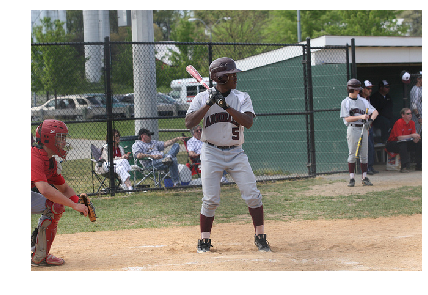

In [0]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a kitchen counter with a tray of food on it


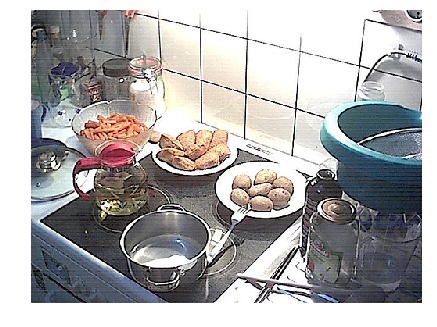

a man is flying a kite on the beach


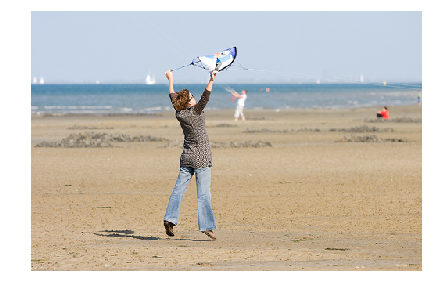

a man riding a skateboard down a street


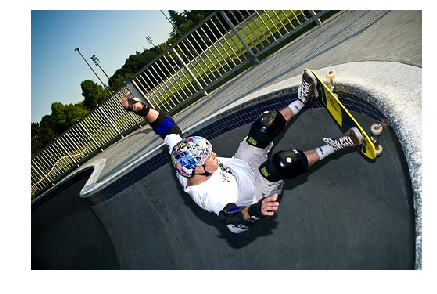

a tennis player is hitting the ball with a racket


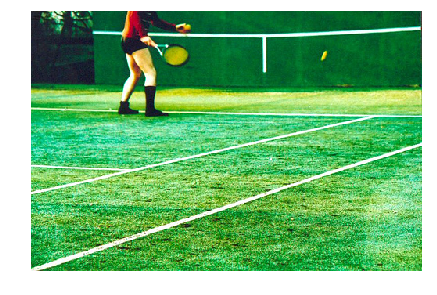

a man standing in a room with a ladder


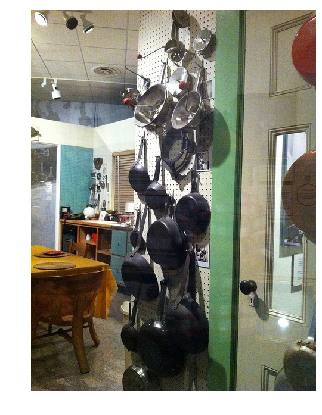

a guitar case and a laptop computer on a table


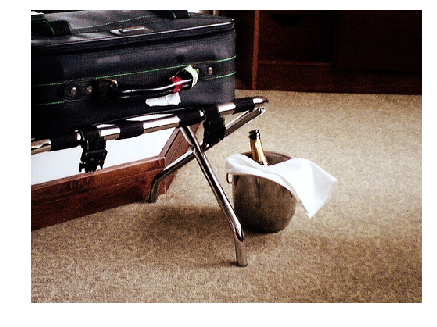

a desk with a laptop computer and a keyboard


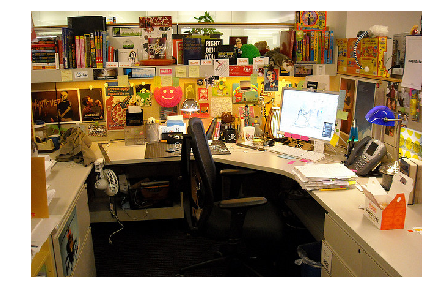

a man riding a snowboard down a snow covered slope


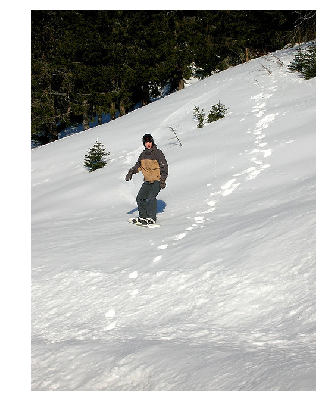

a white and blue bus with a sign on it


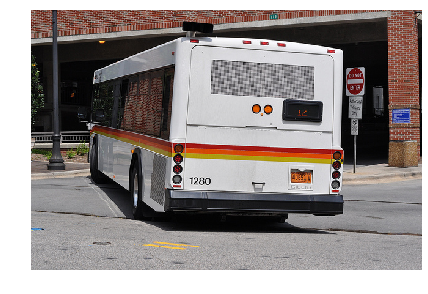

a dog is looking at a cow in a field


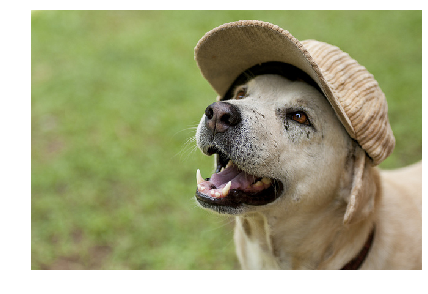

In [0]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)